# Практика: Архитектура GCN (Graph Convolutional Network)
### Цель:
- Понять основы графов и GCN
- Изучить архитектуру GCN
- Реализовать и обучить GCN графовом датасете (Cora)


In [ ]:
!pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import RandomLinkSplit
import networkx as nx

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Загрузка и визуализация графовых данных

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


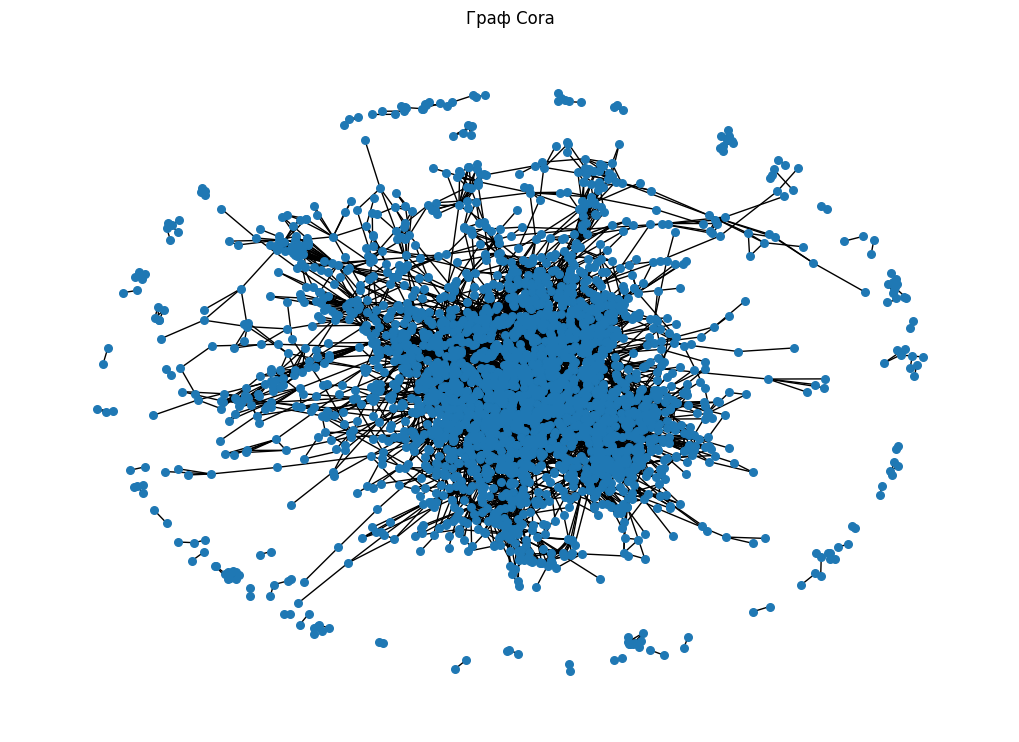

In [ ]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 7))
nx.draw(G, node_size=30, with_labels=False)
plt.title('Граф Cora')
plt.show()

## Теория: Как работает GCN?
GCN использует локальную агрегацию информации от соседей:
$$ h^{(l+1)} = \sigma(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2} h^{(l)} W^{(l)}) $$
- $\tilde{A} = A + I$ — матрица смежности с самосвязями
- $\tilde{D}$ — соответствующая диагональная матрица степеней
- $W^{(l)}$ — обучаемые параметры слоя
- $\sigma$ — функция активации (обычно ReLU)

## Реализация модели GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### Обучение GCN модели

In [ ]:
import copy

def train_node_classification(model, data, optimizer, epochs=200, patience=20):
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # TRAIN
        model.train()
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # VALIDATION
        model.eval()
        val_acc = evaluate_node_classification(model, data, data.val_mask)
        val_accuracies.append(val_acc)


        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break


    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_accuracies



def evaluate_node_classification(model, data, mask):
    """
    Оценка точности модели на подмножестве узлов, заданном маской.

    Args:
        model: обученная GNN-модель
        data: граф
        mask: булевый тензор маски (train_mask, val_mask, test_mask)

    Returns:
        float: accuracy на выбранной части графа
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        acc = (pred == data.y[mask]).sum().item() / mask.sum().item()
        return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Инициализация модели
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Обучение
losses, aucs = train_node_classification(model, data, optimizer, epochs=300)

# Оценка на тесте
test_auc = evaluate_node_classification(model, data, data.test_mask)
print(f"Accuracy на тестовой выборке: {test_auc:.4f}")

Epoch 000, Loss: 1.9524, Val Acc: 0.1760
Epoch 010, Loss: 1.8786, Val Acc: 0.2400
Epoch 020, Loss: 1.7987, Val Acc: 0.3120
Epoch 030, Loss: 1.7233, Val Acc: 0.3540
Epoch 040, Loss: 1.6311, Val Acc: 0.4260
Epoch 050, Loss: 1.5431, Val Acc: 0.5140
Epoch 060, Loss: 1.4610, Val Acc: 0.5600
Epoch 070, Loss: 1.3673, Val Acc: 0.5920
Epoch 080, Loss: 1.2870, Val Acc: 0.6200
Epoch 090, Loss: 1.2623, Val Acc: 0.6380
Epoch 100, Loss: 1.1424, Val Acc: 0.6620
Epoch 110, Loss: 1.0831, Val Acc: 0.6820
Epoch 120, Loss: 1.0324, Val Acc: 0.7000
Epoch 130, Loss: 0.9443, Val Acc: 0.7080
Epoch 140, Loss: 0.8940, Val Acc: 0.7160
Epoch 150, Loss: 0.8349, Val Acc: 0.7200
Epoch 160, Loss: 0.8118, Val Acc: 0.7320
Epoch 170, Loss: 0.7372, Val Acc: 0.7380
Epoch 180, Loss: 0.7142, Val Acc: 0.7400
Epoch 190, Loss: 0.6380, Val Acc: 0.7500
Epoch 200, Loss: 0.6056, Val Acc: 0.7480
Epoch 210, Loss: 0.6122, Val Acc: 0.7480
Early stopping at epoch 210
Accuracy на тестовой выборке: 0.7850


### Оценка качества модели

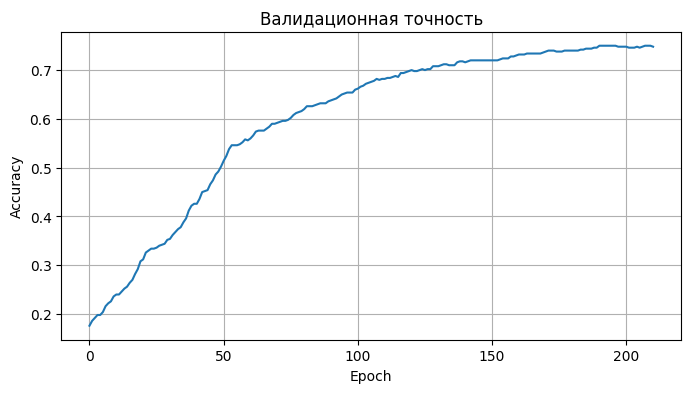

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(aucs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Валидационная точность")
plt.grid(True)
plt.show()

# Link prediction

# Задача Link Prediction

Задача **link prediction** — определить, существует ли ребро между двумя узлами графа или может появиться в будущем.

### Формальная постановка

Пусть дан граф:

$$
G = (V, E),
$$

где (V) — множество узлов, а (E) — множество рёбер.

Необходимо обучить модель:

$$
f(u, v) \rightarrow {0, 1},
$$

которая для пары узлов ((u, v)) предсказывает:

* **1**, если между ними есть или может появиться ребро
* **0**, если ребра нет



### Для чего используется link prediction?

* рекомендательные системы (друзья, товары, контакты)
* социальные сети (новые связи)
* биоинформатика (взаимодействия белков/генов)
* научные графы (предсказание отсутствующих ссылок)






In [ ]:
# Загрузим граф Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

### Позитивные и негативные примеры

* **Позитивные примеры:**
  пары узлов ((u, v)), между которыми есть ребро:
  $$(u, v) \in E$$

* **Негативные примеры:**
  пары узлов без ребра:
  $$(u, v) \notin E$$



### Как обучается модель?

1. GNN-энкодер вычисляет эмбеддинги узлов:

   $$
   z_u, ; z_v
   $$

2. Декодер оценивает вероятность существования ребра.
   Часто используется скалярное произведение:

   $$
   \hat{y}_{uv} = \sigma(z_u^\top z_v)
   $$

3. Модель обучается минимизировать бинарную cross-entropy:

   $$
   \mathcal{L} = -[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]
   $$



### Почему важно скрывать часть рёбер?

Если модель увидит тестовое ребро в графе, она может «подсмотреть» наличие связи через соседей.

Поэтому `RandomLinkSplit` создаёт:

* **train-граф:** только обучающие рёбра
* **val-граф:** только train рёбра
* **test-граф:** train + val рёбра




In [ ]:
# Применим RandomLinkSplit
transform = RandomLinkSplit(
    is_undirected=True,              # Граф без направлений
    split_labels=True,               # Метки (0/1) будут созданы
    add_negative_train_samples=True  # Добавить отрицательные примеры в train
)

train_data, val_data, test_data = transform(data)


Метки (pos/neg пары) лежат в отдельных структурах:

* `train_pos_edge_label_index`, `train_neg_edge_label_index`
* `val_pos_edge_label_index`, `val_neg_edge_label_index`
* `test_pos_edge_label_index`, `test_neg_edge_label_index`

In [ ]:
# Посмотреть, сколько примеров
print(train_data.pos_edge_label_index.shape)  # Примеры "ребро есть"
print(train_data.neg_edge_label_index.shape)  # Примеры "ребра нет"


torch.Size([2, 3696])
torch.Size([2, 3696])


In [ ]:
# Определим GCN Encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
def evaluate_link_prediction(model, data):
    """
    Оценка link prediction модели (dot-product decoder) по AUC и Average Precision.
    """
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)

        # Пары узлов
        pos_edge = data.pos_edge_label_index
        neg_edge = data.neg_edge_label_index

        # Скалярное произведение (dot product)
        # Это декодер, который предсказывает связь между узлами:
        # если узлы похожи, их эмбеддинги близки → dot product большой
        # если узлы несвязаны, dot product маленький
        # Это стандартный метод в GAE/VGAE, Node2Vec, DeepWalk, LINE и многих GNN-подходах.
        pos_score = (z[pos_edge[0]] * z[pos_edge[1]]).sum(dim=1)
        neg_score = (z[neg_edge[0]] * z[neg_edge[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score], dim=0)

        # Формируем правильные метки:
        # 1 для позитивных рёбер
        # 0 для негативных рёбер
        labels = torch.cat([
            torch.ones(pos_score.size(0)),
            torch.zeros(neg_score.size(0))
        ]).to(scores.device)

        # Превращаем скалярные произведения в вероятности
        probs = torch.sigmoid(scores)
        auc = roc_auc_score(labels.cpu(), probs.cpu())
        ap = average_precision_score(labels.cpu(), probs.cpu())

        return auc, ap

import copy

def train_link_prediction(model, train_data, val_data, optimizer, epochs=100, patience=10):
    """
    Обучение модели link prediction с:
      - binary cross entropy loss
      - валидацией по AUC и BCE
      - ранней остановкой
      - сохранением лучших весов модели

    Args:
        model: GNN энкодер (например, GCNEncoder)
        train_data: Data объект для обучения
        val_data: Data объект для валидации
        optimizer: torch.optim.Adam / SGD
        epochs: максимальное число эпох
        patience: сколько эпох ждать улучшения val_loss или val_auc

    Returns:
        train_losses, val_losses, val_aucs
    """

    train_losses = []
    val_losses = []
    val_aucs = []

    best_val_auc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):

        # TRAIN
        model.train()
        optimizer.zero_grad()

        # Эмбеддинги train-графа
        z = model(train_data.x, train_data.edge_index)

        # Позитивные/негативные пары
        pos_edge = train_data.pos_edge_label_index
        neg_edge = train_data.neg_edge_label_index

        # Dot-product decoder
        pos_score = (z[pos_edge[0]] * z[pos_edge[1]]).sum(dim=1)
        neg_score = (z[neg_edge[0]] * z[neg_edge[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score], dim=0)

        labels = torch.cat([
            torch.ones(pos_score.size(0)),
            torch.zeros(neg_score.size(0))
        ]).to(scores.device)

        # BCE loss
        loss = F.binary_cross_entropy_with_logits(scores, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # VALIDATION
        model.eval()
        with torch.no_grad():

            # AUC/AP — более правильная метрика для link prediction
            val_auc, val_ap = evaluate_link_prediction(model, val_data)
            val_aucs.append(val_auc)

            # А также считаем валидизационный BCE loss (для более стабильной ранней остановки)
            z_val = model(val_data.x, val_data.edge_index)
            pos_val = val_data.pos_edge_label_index
            neg_val = val_data.neg_edge_label_index

            pos_val_score = (z_val[pos_val[0]] * z_val[pos_val[1]]).sum(dim=1)
            neg_val_score = (z_val[neg_val[0]] * z_val[1]).sum(dim=1)

            val_scores = torch.cat([pos_val_score, neg_val_score], dim=0)
            val_labels = torch.cat([
                torch.ones(pos_val_score.size(0)),
                torch.zeros(neg_val_score.size(0))
            ]).to(scores.device)

            val_loss = F.binary_cross_entropy_with_logits(val_scores, val_labels)
            val_losses.append(val_loss.item())


        print(f"Epoch {epoch:03d}, "
              f"Train Loss: {loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}, "
              f"Val AUC: {val_auc:.4f}")


        # Вариант: используем метрику AUC как главный критерий
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Если долго нет улучшений — остановить обучение
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (best AUC = {best_val_auc:.4f})")
            break

    # LOAD BEST MODEL
    if best_model_state is not None:
        print("Loading the best model weights...")
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_aucs



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNEncoder(dataset.num_node_features, 64, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train_data, val_data = train_data.to(device), val_data.to(device)

train_losses, val_losses, val_aucs = train_link_prediction(model, train_data, val_data, optimizer, epochs=200)


Epoch 000, Train Loss: 0.6562, Val Loss: 0.8307, Val AUC: 0.7774
Epoch 001, Train Loss: 0.5976, Val Loss: 2.2643, Val AUC: 0.6959
Epoch 002, Train Loss: 1.6971, Val Loss: 0.6559, Val AUC: 0.8502
Epoch 003, Train Loss: 0.5402, Val Loss: 1.5166, Val AUC: 0.7249
Epoch 004, Train Loss: 0.9425, Val Loss: 1.0435, Val AUC: 0.7546
Epoch 005, Train Loss: 0.7266, Val Loss: 0.7244, Val AUC: 0.8181
Epoch 006, Train Loss: 0.5810, Val Loss: 0.6700, Val AUC: 0.8595
Epoch 007, Train Loss: 0.5877, Val Loss: 0.6594, Val AUC: 0.8684
Epoch 008, Train Loss: 0.6009, Val Loss: 0.6515, Val AUC: 0.8547
Epoch 009, Train Loss: 0.6074, Val Loss: 0.6477, Val AUC: 0.8300
Epoch 010, Train Loss: 0.6041, Val Loss: 0.6509, Val AUC: 0.8094
Epoch 011, Train Loss: 0.5979, Val Loss: 0.6410, Val AUC: 0.8183
Epoch 012, Train Loss: 0.5873, Val Loss: 0.6170, Val AUC: 0.8406
Epoch 013, Train Loss: 0.5714, Val Loss: 0.5954, Val AUC: 0.8559
Epoch 014, Train Loss: 0.5570, Val Loss: 0.5775, Val AUC: 0.8621
Epoch 015, Train Loss: 0.

In [ ]:
# Оценка на тесте
test_auc, test_ap = evaluate_link_prediction(model, test_data)

print(f"ROC-AUC на тестовой выборке: {test_auc:.4f}")
print(f"Precision на тестовой выборке: {test_ap:.4f}")

ROC-AUC на тестовой выборке: 0.8971
Precision на тестовой выборке: 0.9009


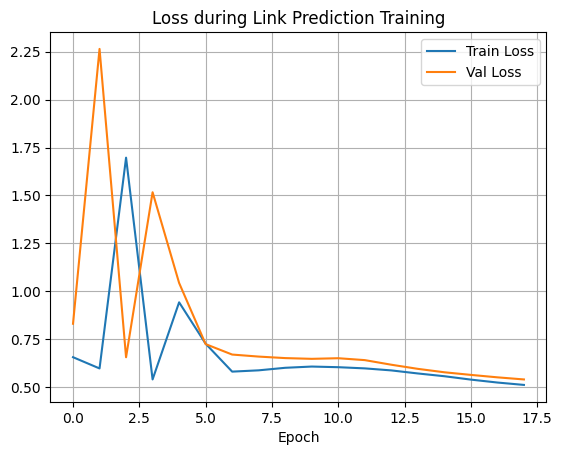

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.title("Loss during Link Prediction Training")
plt.legend()
plt.grid(True)
plt.show()
